# Classificacao de SPAMs em mensagens SMS com Naive Bayes

Aprenderemos um pouco de extracao de features textuais (Vetorizacao / Bag of Words).

Utilizaremos diferentes tipos de Classificadores Naive Bayes.

Analisaremos os resultados dos modelos criados utilizando Matriz de Confusao, Precision, Recall, F1, ROC Curve, ROC-AUC.

Dataset:

https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

#### Imports

In [276]:
import requests
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay

#### Carga do Dataset

In [277]:
orig_url='https://drive.google.com/file/d/19qYhN6D7h65WBUdNMUsboyJv5qlQeNbh/view?usp=sharing'
file_id = orig_url.split('/')[-2]
dwn_url='https://drive.google.com/uc?export=download&id=' + file_id
url = requests.get(dwn_url).text
csv_raw = StringIO(url)
df = pd.read_csv(csv_raw, encoding = "ISO-8859-1")
df.head()

,label,text,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## Pre-processamento

In [278]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)

In [279]:
df.shape

(5572, 2)

In [280]:
df.isnull().sum()

,0
label,0
text,0


In [281]:
df['label'].value_counts()

,count
label,
ham,4825
spam,747


In [282]:
df.describe()

,label,text
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [283]:
df['label'].unique()

array(['ham', 'spam'], dtype=object)

In [284]:
sdf = df.loc[(df.label == 'spam')]
sdf.describe()

,label,text
count,747,747
unique,1,653
top,spam,Please call our customer service representativ...
freq,747,4


In [285]:
hdf = df.loc[(df.label == 'ham')]
hdf.describe()

,label,text
count,4825,4825
unique,1,4516
top,ham,"Sorry, I'll call later"
freq,4825,30


In [286]:
enc = OrdinalEncoder(categories=[['ham', 'spam']], dtype=np.int8)
df['label'] = enc.fit_transform(df[['label']].values)

In [287]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


## Datset Split

In [288]:
X = df['text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [289]:
X_train.shape

(3900,)

In [290]:
X_test.shape

(1672,)

## Extracao de Features Textuais

### Definindo o Vetorizador de Termos

In [291]:
# instanciando o vetorizador
cvec = CountVectorizer(stop_words ='english')

cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [292]:
cvec.vocabulary_ # Informa a posição de cada feature

{'review': 5158,
 'fantastic': 2523,
 'nokia': 4306,
 'gage': 2777,
 'game': 2784,
 'deck': 2007,
 'club': 1683,
 'www': 6808,
 'cnupdates': 1697,
 'com': 1726,
 'newsletter': 4275,
 'unsubscribe': 6400,
 'alerts': 833,
 'reply': 5106,
 'word': 6757,
 'just': 3490,
 'got': 2903,
 'outta': 4487,
 'class': 1657,
 'gonna': 2884,
 'gym': 2977,
 'coming': 1738,
 'friday': 2727,
 'leave': 3642,
 'pongal': 4738,
 'news': 4274,
 'work': 6759,
 'place': 4669,
 'hi': 3092,
 'dear': 1992,
 'urgnt': 6426,
 'don': 2187,
 'know': 3561,
 'whats': 6676,
 'problem': 4851,
 'want': 6586,
 'tell': 6037,
 'wating': 6610,
 'friend': 2731,
 'says': 5299,
 'upping': 6414,
 'order': 4458,
 'grams': 2921,
 'lt': 3813,
 'gt': 2957,
 'telly': 6041,
 'brdget': 1340,
 'jones': 3463,
 'yes': 6859,
 'saw': 5295,
 'message': 4004,
 'new': 4270,
 'voicemail': 6529,
 '08719181513': 146,
 'yesterday': 6861,
 'true': 6291,
 'thinking': 6112,
 'day': 1982,
 'great': 2936,
 'ok': 4402,
 'floppy': 2640,
 'snappy': 5603,
 'h

In [293]:
cvec.get_feature_names_out()

array(['00', '000', '000pes', ..., 'zogtorius', 'zoom', 'zouk'],
      dtype=object)

## Transformando os Dados de Treino e Teste

In [294]:
X_train_transf = cvec.transform(X_train)
X_test_transf = cvec.transform(X_test)
X_test_transf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## Treinando e executando o modelo

In [295]:
# Define o estimador
#est = MultinomialNB(alpha=0.2)
est = BernoulliNB()

# Treina o modelo
est.fit(X_train_transf,y_train)

# Realiza as predicoes
y_pred = est.predict(X_test_transf)

# TODO 1 parametro
y_pred_prob = est.predict_proba(X_test_transf)

### Entendendo o conteudo das probabilidades

In [296]:
#observando o conteudo de y_pred_prob
y_pred_prob #exibe conteudo
#y_pred[0] # classificacao para o 1o exemplo
#y_pred_prob[0] #probabilidades para primeiro exemplo (para cada classe)
#y_pred_prob[0][0] + y_pred_prob[0][1]  # approx 1.0

array([[9.99999783e-01, 2.17490731e-07],
       [9.99995755e-01, 4.24497876e-06],
       [9.98366146e-01, 1.63385395e-03],
       ...,
       [9.99999998e-01, 1.75823639e-09],
       [9.99999999e-01, 1.39680930e-09],
       [9.99999960e-01, 4.02591920e-08]])

## Analise dos Resultados

### Observando a Matriz de Confusao

In [297]:
confusion_matrix(y_test,y_pred)

array([[1452,    1],
       [  48,  171]])

### Calculando as Metricas

In [298]:
print('Accuracy: ', accuracy_score(y_test,y_pred), '\n')
print('Precision: ', precision_score(y_test,y_pred), '\n')
print('Recall: ', recall_score(y_test,y_pred), '\n')
print('F1: ', f1_score(y_test,y_pred))

Accuracy:  0.9706937799043063 

Precision:  0.9941860465116279 

Recall:  0.7808219178082192 

F1:  0.8746803069053708


### Curva ROC (ROC-Curve)

#### Calculando os elementos da Curva ROC

In [299]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_prob[:,1])

In [300]:
print('False Positive Rates:\n\n', false_positive_rate, '\n')
print('True Positive Rates:\n\n', true_positive_rate, '\n')
print('Thresholds:\n\n', thresholds)

False Positive Rates:

 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.88231246e-04 6.88231246e-04 6.88231246e-04
 6.88231246e-04 1.37646249e-03 1.37646249e-03 1.37646249e-03
 1.37646249e-03 2.06469374e-03 2.06469374e-03 2.75292498e-03
 2.75292498e-03 4.81761872e-03 4.81761872e-03 5.50584997e-03
 5.50584997e-03 6.19408121e-03 6.19408121e-03 8.25877495e-03
 8.25877495e-03 8.94700619e-03 8.94700619e-03 1.03234687e-02
 1.03234687e-02 1.10116999e-02 1.10116999e-02 1.65175499e-02
 1.65175499e-02 1.99587061e-02 1.99587061e-02 2.33998624e-02
 2.47763248e-02 3.44115623e-02 3.44115623e-02 3.57880248e-02
 3.57880248e-02 4.12938747e-02 4.26703372e-02 8.25877495e-02
 8.25877495e-02 8.53406745e-02 8.67171370e-02 9.63523744e-02
 9.77288369e-02 1.10805231e-01 1.10805231e-01 1.13558156e-01


#### Plotando o grafico da Curva ROC

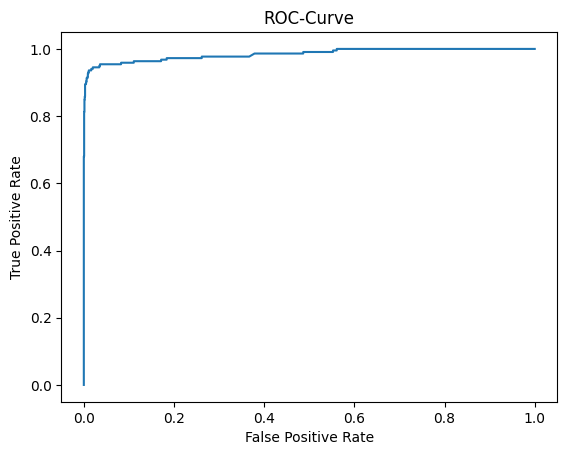

In [301]:
%matplotlib inline
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-Curve')
plt.plot(false_positive_rate, true_positive_rate)

#### Calculando a ROC-AUC

In [302]:
roc_auc = auc(false_positive_rate, true_positive_rate)
print('ROC-AUC: ', roc_auc)

ROC-AUC:  0.9845226534928522


### Curva-PR (PR-Curve)

#### Calculando os elementos da PR-Curve

In [303]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])

#### Plotando o grafico da PR-Curve

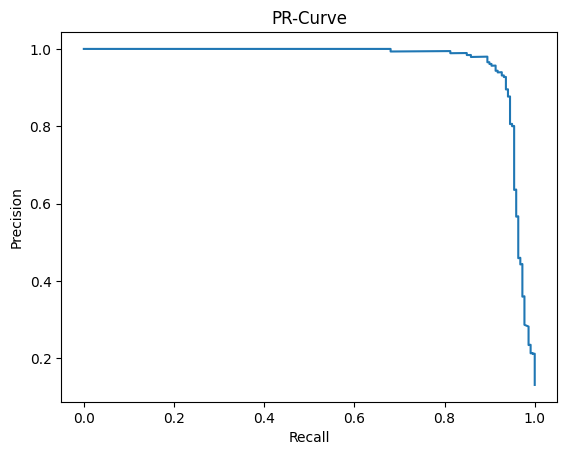

In [304]:
%matplotlib inline
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR-Curve')
plt.plot(recall, precision)

#### Calculando a PR-AUC

In [305]:
pr_auc = auc(recall, precision)
print('PR-AUC: ', pr_auc)

PR-AUC:  0.9640797671097644


### Fazendo plots mais facilmente

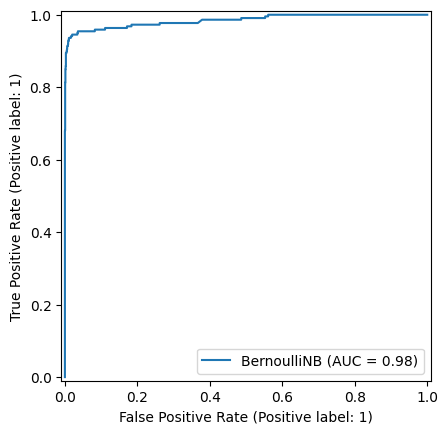

In [306]:
RocCurveDisplay.from_estimator(est, X_test_transf, y_test)

#### Curva-ROC (ROC-Curve)

Utilizando `plot_roc_curve` (em sklearn.metrics) para plotar a curva ROC diretamente, sem calcular os elementos antes

#### PR-Curve
Plotando a PR-Curve com `plot_precision_recall_curve` (em `sklearn.metrics`)

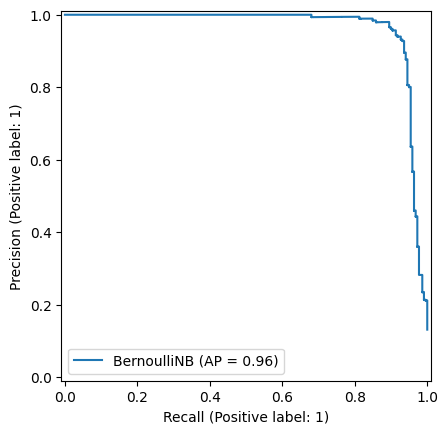

In [307]:
PrecisionRecallDisplay.from_estimator(est, X_test_transf, y_test)

#### Plotando a Matriz de Confusao



Sem Formatacao

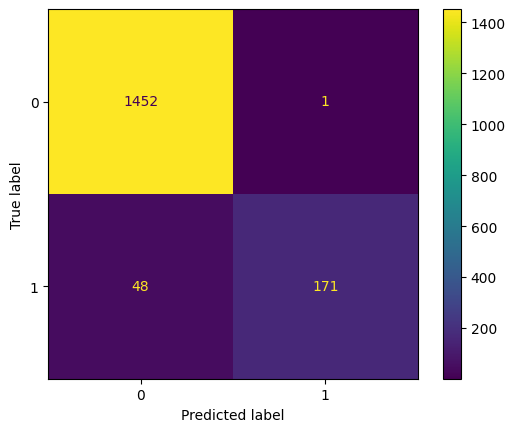

In [308]:
ConfusionMatrixDisplay.from_estimator(est, X_test_transf, y_test)

Com Formatacao

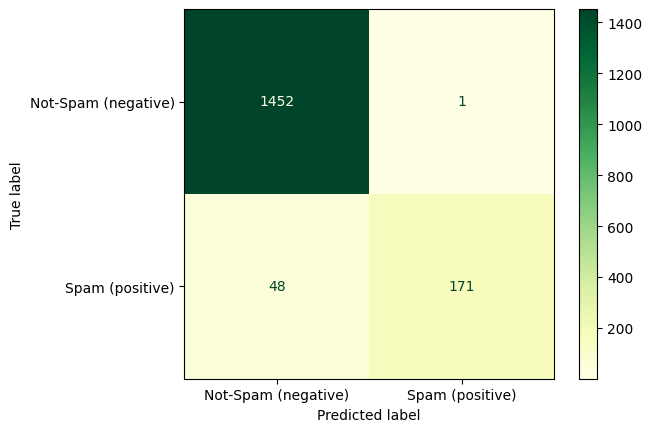

In [309]:
class_names = ['Not-Spam (negative)', 'Spam (positive)']
ConfusionMatrixDisplay.from_estimator(est, X_test_transf, y_test, values_format = '', display_labels=class_names, cmap=plt.cm.YlGn)